In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
!pip install torchviz  --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install graphviz  --quiet

In [ ]:
import opendatasets as od
import os
import random

from PIL import Image
import glob
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from graphviz import Digraph
from graphviz import Source

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torchviz import make_dot

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Load Dataset and Normalize

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/tongpython/cat-and-dog'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: inoikim
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:03<00:00, 58.2MB/s]


In [ ]:
image_path = "/content/cat-and-dog"
train_dir = f"{image_path}/training_set/training_set"
test_dir = f"{image_path}/test_set/test_set"

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# Automatic Image Augmentation : https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
# Create training transform with TriviaAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

In [ ]:
# Turn image folders into Datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# get batch of images and labels from DataLoader
img_batch, label_batch = next(iter(train_dataloader))
print(img_batch[0].shape, label_batch.shape)
# get single image from batch and unsqueeze image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f'Single image shape: {img_single.shape}\n')

torch.Size([3, 224, 224]) torch.Size([32])
Single image shape: torch.Size([1, 3, 224, 224])



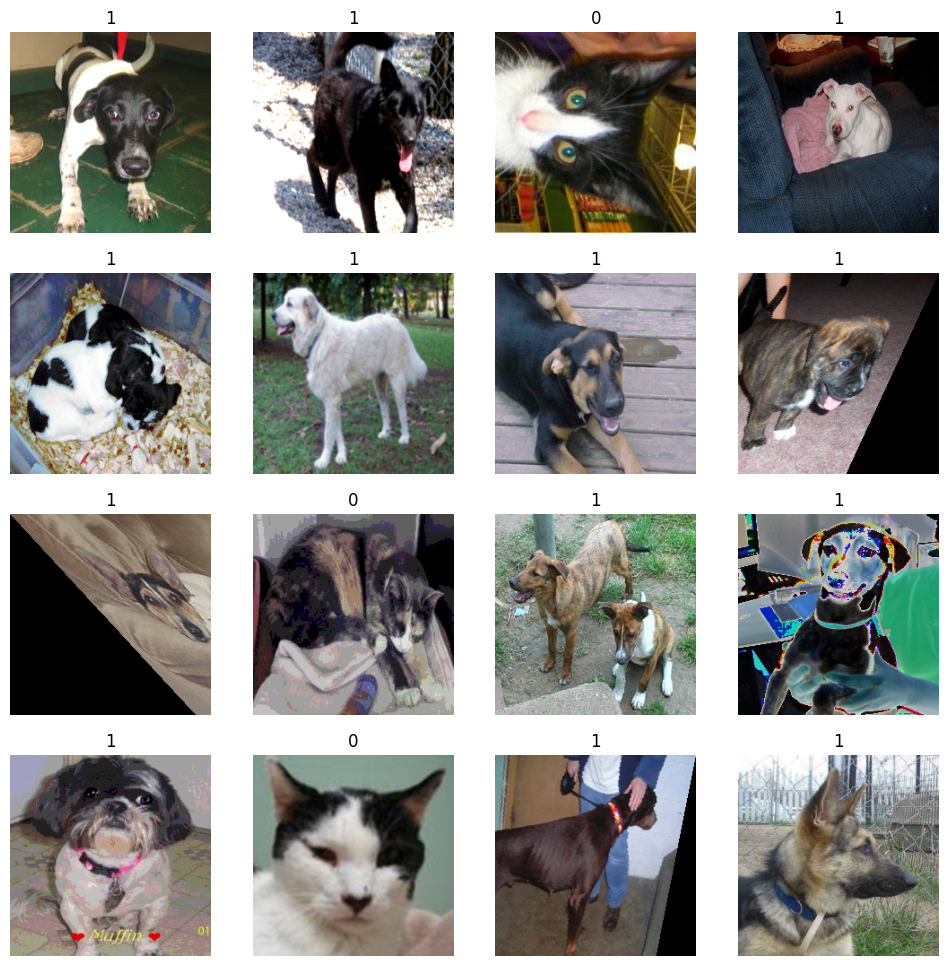

In [ ]:
figure = plt.figure(figsize=(12,12))

cols, rows = 4,4
for i in range(1, cols*rows+1):
  image = img_batch[i].squeeze(dim=0)
  label_idx = label_batch[i].item()

  figure.add_subplot(rows, cols, i)
  plt.title(label_idx)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
plt.show()

2. Define Convolutional Neural Network

In [ ]:
class ImageClassifier(nn.Module):

  def __init__(self):
    super(ImageClassifier, self).__init__()

    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(3,64,3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(64,512, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2)
    )
    self.conv_layer_3 = nn.Sequential(
        nn.Conv2d(512,512, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
         nn.Flatten(),
         nn.Linear(in_features = 512*3*3, out_features=2)
     )

  def forward(self, x):
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.classifier(x)
    return x

  def compute_l1_loss(self,w):
    return torch.abs(w).sum()

model = ImageClassifier().to(device)

In [ ]:
layer_1 = model.conv_layer_1
print('Convolution Layer :', layer_1)

y1 = layer_1(img_single)
print('Output Shape:',y1.shape)

dot = make_dot(y1, params=dict(model.named_parameters()))

dot.graph_attr['size'] = "12,12"

dot.render('layer_1', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 64, 112, 112])


'layer_1.png'

In [ ]:
layer_2 = model.conv_layer_2
print('Convolution Layer :', layer_2)

y2 = layer_2(y1)
print('Output Shape:',y2.shape)

dot = make_dot(y2, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_2', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 512, 56, 56])


'layer_2.png'

In [ ]:
layer_3 = model.conv_layer_3
print('Convolution Layer :', layer_3)

y3 = layer_3(y2)
print('Output Shape:',y3.shape)

dot = make_dot(y3, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_3', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 512, 28, 28])


'layer_3.png'

In [ ]:
layer_4 = model.conv_layer_3
print('Convolution Layer :', layer_4)

y4 = layer_4(y3)
print('Output Shape:',y4.shape)

dot = make_dot(y4, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_4', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 512, 14, 14])


'layer_4.png'

In [ ]:
layer_5 = model.conv_layer_3
print('Convolution Layer :', layer_5)

y5 = layer_5(y4)
print('Output Shape:',y5.shape)

dot = make_dot(y5, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_5', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 512, 7, 7])


'layer_5.png'

In [ ]:
layer_6 = model.conv_layer_3
print('Convolution Layer :', layer_6)

y6 = layer_6(y5)
print('Output Shape:',y6.shape)

dot = make_dot(y6, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_6', format='png', cleanup=True)

Convolution Layer : Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output Shape: torch.Size([1, 512, 3, 3])


'layer_6.png'

In [ ]:
layer_7 = model.classifier
print('Linear Layer :', layer_7)

y7 = layer_7(y6)
print('Output Shape:',y7.shape)

dot = make_dot(y7, params=dict(model.named_parameters()))
dot.graph_attr['size'] = "12,12"

dot.render('layer_7', format='png', cleanup=True)

Linear Layer : Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4608, out_features=2, bias=True)
)
Output Shape: torch.Size([1, 2])


'layer_7.png'

In [ ]:
 # define labels
labels = torch.rand(1).to(device)
model = ImageClassifier().to(device)
img_single = img_single.to(device)

# forward propagation
prediction = model(img_single)

# define loss
loss = (prediction - labels).sum()

# backward pass
loss.backward()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# gradient descent
optimizer.step()

# Computational Graph
dot = make_dot(prediction,
         params=dict(model.named_parameters()))

dot.graph_attr['size'] = "20,20"

dot.render('final', format='png', cleanup=True)

'final.png'

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo --quiet
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1,3,IMAGE_WIDTH, IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

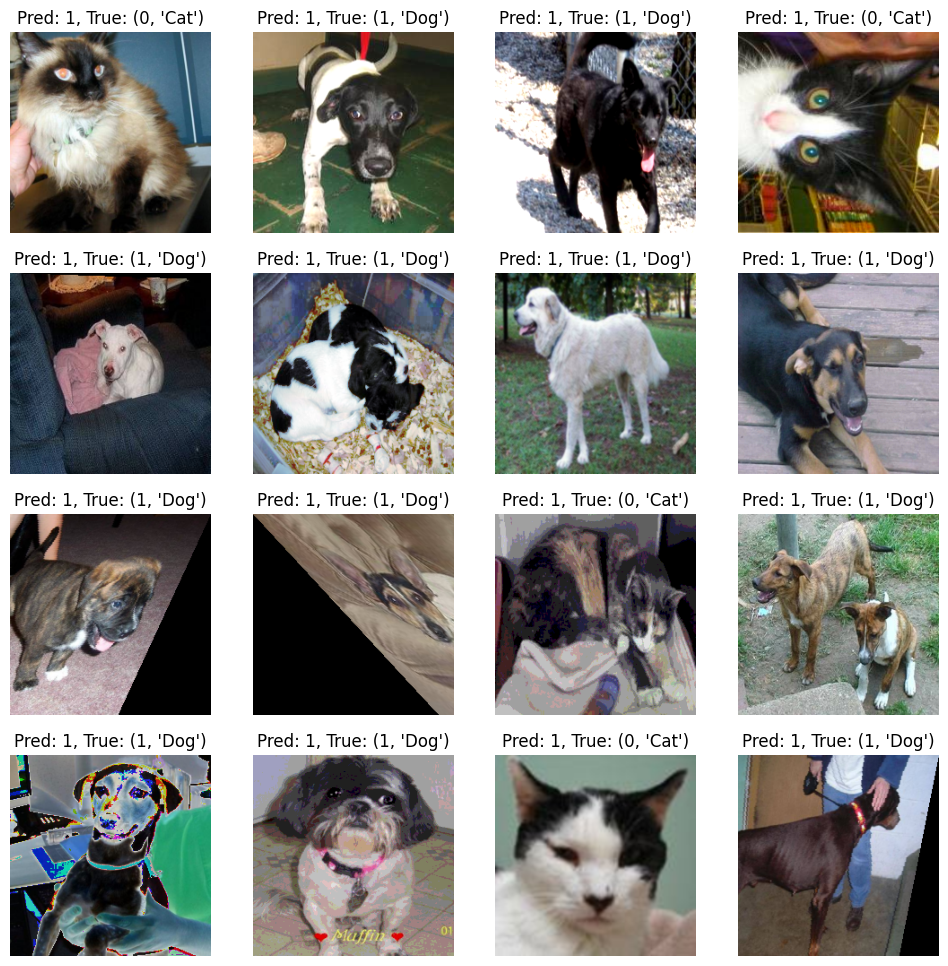

In [ ]:
labels_map = {
    0:'Cat',
    1:'Dog'
}

figure = plt.figure(figsize=(12, 12))

cols, rows = 4, 4
for i in range(1, cols * rows + 1):

    image = img_batch[i-1].unsqueeze(dim=0)  # Unsqueeze to add batch dimension
    label_idx = label_batch[i-1].item()
    label = labels_map[label_idx]

    if torch.cuda.is_available():
        image = image.cuda()

    model.eval()
    with torch.no_grad():
        pred = model(image)
        pred_label = torch.argmax(torch.softmax(pred, dim=1), dim=1).item()

    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {pred_label}, True: {label_idx, label}")
    plt.axis('off')
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0).numpy())  # Squeeze to remove batch dimension

plt.show()

3. Define Loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 1e-4)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

4. Create train & test loop

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer):
  model.train()
  train_loss, train_acc = 0,0

  #loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimize zero grad
    optimizer.zero_grad()

    # Compute L1 loss component
    #l1_weight = 1
    #l1_loss = 0
    #for parameter in model.parameters():
    #  l1_loss += parameter.abs().sum()
    #loss += l1_weight * l1_loss

    # Loss backward
    loss.backward()

    # Optimizer
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  #Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model, dataloader, loss_fn):
  # put model in eval mode
  model.eval()

  test_loss, test_acc = 0,0

  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      #calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
  #create empty result dic
  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

  early_stopping = EarlyStopping(patience=5, verbose=True)

  # loop through training and testing steps for number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}" )

    results['train_loss'].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    early_stopping(test_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

  model.load_state_dict(torch.load('checkpoint.pt'))

  return results

5. Train and eval model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.to(device)
NUM_EPOCHS = 20

start_time = timer()

model_results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS)

end_time = timer()
print(f'Total time: {end_time - start_time:.3f} seconds')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6782 | train_acc: 0.6469 | test_loss: 0.5348 | test_acc: 0.7326
Validation loss decreased (inf --> 0.534843).  Saving model ...
Epoch: 2 | train_loss: 0.5841 | train_acc: 0.6990 | test_loss: 0.5130 | test_acc: 0.7469
Validation loss decreased (0.534843 --> 0.512993).  Saving model ...
Epoch: 3 | train_loss: 0.5366 | train_acc: 0.7328 | test_loss: 0.5516 | test_acc: 0.7448
EarlyStopping counter: 1 out of 5
Epoch: 4 | train_loss: 0.4711 | train_acc: 0.7741 | test_loss: 0.5222 | test_acc: 0.7560
EarlyStopping counter: 2 out of 5
Epoch: 5 | train_loss: 0.4280 | train_acc: 0.7967 | test_loss: 0.3790 | test_acc: 0.8364
Validation loss decreased (0.512993 --> 0.378981).  Saving model ...
Epoch: 6 | train_loss: 0.3987 | train_acc: 0.8140 | test_loss: 0.4099 | test_acc: 0.8117
EarlyStopping counter: 1 out of 5
Epoch: 7 | train_loss: 0.3586 | train_acc: 0.8372 | test_loss: 0.3537 | test_acc: 0.8414
Validation loss decreased (0.378981 --> 0.353749).  Saving model ...
Epoc

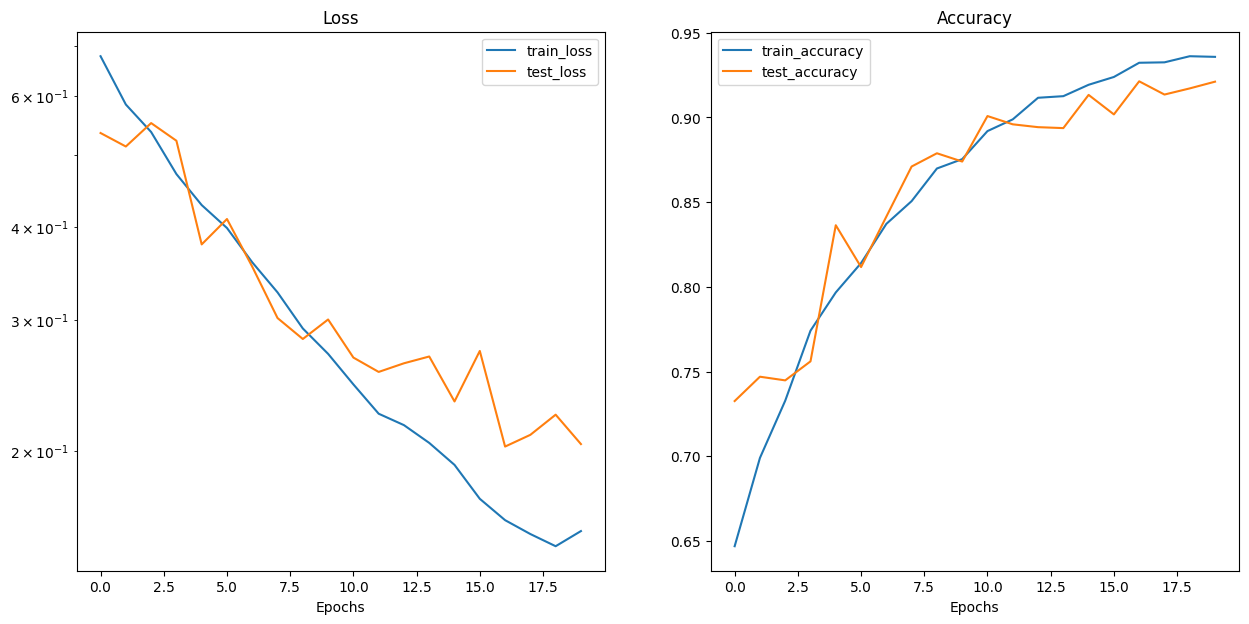

In [ ]:
def plot_loss_curves(results):
  results = dict(list(model_results.items()))

  # get loss value from result dictionary
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  #epoch
  epochs = range(len(results['train_loss']))

  plt.figure(figsize = (15,7))

  #plot loss
  plt.subplot(121)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.yscale('log')
  plt.legend()

  # Plot accuracy
  plt.subplot(122)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
plot_loss_curves(model_results)

Model Save

In [ ]:
PATH = './cat_dog_classification.pth'
torch.save(ImageClassifier().state_dict(), PATH)

In [ ]:
model = ImageClassifier()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
print(model)

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear